In [13]:
# plotting stuff
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import cartopy.crs as crs
from cartopy.feature import NaturalEarthFeature

# built in python modules
import datetime
import os
import inspect
import sys

# python add-ons
import numpy as np
import pandas as pd
import xarray as xr
import netCDF4
from wrf import (to_np, getvar, ALL_TIMES, smooth2d, get_cartopy, cartopy_xlim,
                 cartopy_ylim, latlon_coords)
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

# Import the pvlib module
if sys.platform == 'linux':
    sys.path.append('/home/jsward/Documents/01_Research/01_Renewable_Analysis/WRF/pvlib-python')
else:
    sys.path.append('/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/pvlib-python')
import pvlib
from pvlib.wrfcast import WRF

In [26]:
# Verbose setting
verbose = True

# Find the absolute file path to your pvlib installation
pvlib_abspath = os.path.dirname(os.path.abspath(inspect.getfile(pvlib)))

# Open the NetCDF file
ncfile_orig = os.path.join(pvlib_abspath, 'data', 'wrfout_d01_2011-01-24_01:00:00')
ncdata_orig = netCDF4.Dataset(ncfile_orig)
ncfile = os.path.join(pvlib_abspath, 'data', 'wrfout_solar_d01_2011-01-24_01:00:00.nc')
ncdata = xr.open_dataset(ncfile)
if verbose:
    print(ncdata)

<xarray.Dataset>
Dimensions:             (Time: 24, south_north: 191, west_east: 191)
Coordinates:
  * Time                (Time) datetime64[ns] 2011-01-24T01:00:00 ... 2011-01-25
  * south_north         (south_north) int64 0 1 2 3 4 5 ... 186 187 188 189 190
  * west_east           (west_east) int64 0 1 2 3 4 5 ... 186 187 188 189 190
Data variables:
    lon                 (Time, south_north, west_east) float32 ...
    lat                 (Time, south_north, west_east) float32 ...
    temp_air            (Time, south_north, west_east) float32 ...
    wind_speed_u        (Time, south_north, west_east) float32 ...
    wind_speed_v        (Time, south_north, west_east) float32 ...
    dni                 (Time, south_north, west_east) float32 ...
    dhi                 (Time, south_north, west_east) float32 ...
    ghi                 (Time, south_north, west_east) float64 ...
    apparent_zenith     (Time, south_north, west_east) float64 ...
    zenith              (Time, south_north,

In [27]:
# Create an xarray.Dataset from the wrf qurery_variables.
variables = {
            'lat': 'XLAT',
            'lon': 'XLONG', 
            }
ncdata = xr.Dataset.rename(ncdata, variables)
# ncdata = xr.Dataset.reset_coords(ncdata, ['south_north'], drop=True)
# ncdata = xr.Dataset.reset_coords(ncdata, ['west_east'], drop=True)
ncdata = xr.Dataset.set_coords(ncdata, ['XLONG'])
ncdata = xr.Dataset.set_coords(ncdata, ['XLAT'])
if verbose:
    print(ncdata)

<xarray.Dataset>
Dimensions:             (Time: 24, south_north: 191, west_east: 191)
Coordinates:
  * Time                (Time) datetime64[ns] 2011-01-24T01:00:00 ... 2011-01-25
  * south_north         (south_north) int64 0 1 2 3 4 5 ... 186 187 188 189 190
  * west_east           (west_east) int64 0 1 2 3 4 5 ... 186 187 188 189 190
    XLONG               (Time, south_north, west_east) float32 ...
    XLAT                (Time, south_north, west_east) float32 ...
Data variables:
    temp_air            (Time, south_north, west_east) float32 ...
    wind_speed_u        (Time, south_north, west_east) float32 ...
    wind_speed_v        (Time, south_north, west_east) float32 ...
    dni                 (Time, south_north, west_east) float32 ...
    dhi                 (Time, south_north, west_east) float32 ...
    ghi                 (Time, south_north, west_east) float64 ...
    apparent_zenith     (Time, south_north, west_east) float64 ...
    zenith              (Time, south_north,

In [82]:
# Print times
if verbose:
    print(ncdata.Time)
    print(f'\nThe timestr is: {ncdata.Time[0].values}')
    

<xarray.DataArray 'Time' (Time: 24)>
array(['2011-01-24T01:00:00.000000000', '2011-01-24T02:00:00.000000000',
       '2011-01-24T03:00:00.000000000', '2011-01-24T04:00:00.000000000',
       '2011-01-24T05:00:00.000000000', '2011-01-24T06:00:00.000000000',
       '2011-01-24T07:00:00.000000000', '2011-01-24T08:00:00.000000000',
       '2011-01-24T09:00:00.000000000', '2011-01-24T10:00:00.000000000',
       '2011-01-24T11:00:00.000000000', '2011-01-24T12:00:00.000000000',
       '2011-01-24T13:00:00.000000000', '2011-01-24T14:00:00.000000000',
       '2011-01-24T15:00:00.000000000', '2011-01-24T16:00:00.000000000',
       '2011-01-24T17:00:00.000000000', '2011-01-24T18:00:00.000000000',
       '2011-01-24T19:00:00.000000000', '2011-01-24T20:00:00.000000000',
       '2011-01-24T21:00:00.000000000', '2011-01-24T22:00:00.000000000',
       '2011-01-24T23:00:00.000000000', '2011-01-25T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * Time     (Time) datetime64[ns] 2011-01-

In [174]:
def create_plot(cart_proj, data, data_orig, lats, lons, title_str='', save_fig=False, fig_path='./'):
    # Create a figure
    fig = plt.figure(figsize=(12,6))
    # Set the GeoAxes to the projection used by WRF
    ax = plt.axes(projection=cart_proj)

    # Make the countour lines for filled contours for the GHI
    contour_levels = np.linspace(0, 5, 22)
    plt.contourf(to_np(lons), to_np(lats), to_np(data), contour_levels,
                 transform=crs.PlateCarree(),
                 cmap=get_cmap("hot_r"))

    # Format the plot
    format_plot(data_orig, ax, title_str)

    # Save the figure(s)
    if save_fig:
        plt.savefig(fig_path, transparent=True, bbox_inches='tight')

In [167]:
def format_plot(lim_data, ax, title_str=''):
    
    # Download and add the states, coastlines, and lakes
    states = NaturalEarthFeature(category="cultural", scale="50m",
                                 facecolor="none",
                                 name="admin_1_states_provinces_shp")
    ax.add_feature(states, linewidth=.5, edgecolor="black")
#     ax.coastlines(resolution='10m', linewidth=0.8)
    ax.add_feature(cfeature.LAKES.with_scale('50m'), alpha=0.9)
    ax.add_feature(cfeature.OCEAN.with_scale('50m'))

    # Add a color bar
    plt.colorbar(ax=ax, shrink=.98)

    # Set the map bounds
    ax.set_xlim(cartopy_xlim(lim_data))
    ax.set_ylim(cartopy_ylim(lim_data))

    # Add the gridlines
#     ax.gridlines(color="black", linestyle="dotted")
    
    # Add the axis title
    plt.title(title_str)

In [171]:
def plot_daily_GHI(times, hourly=False, save_fig=False, fig_path='./'):
    # Define the time indicies from the times variable
    time_indicies = range(0, len(times))
    # Format the times for title slides
    times_strings_f = times.dt.strftime('%b %d, %Y %H:%M')
    # Get the desired variable(s)
    for tidx in time_indicies:
        timestr = times[tidx].values
        timestr_f = times_strings_f[tidx].values
        if hourly:
            title_str = f'Global Horizontal Irradiance (kW m-2)\n{timestr_f} (UTC)'
        else:
            time_string_f = times[0].dt.strftime('%b %d, %Y')
            title_str = f'Global Horizontal Irradiance (kWh m-2 day-1) \n{time_string_f.values}'
        dni_orig = getvar(ncdata_orig, "SWDDNI", timeidx=tidx)
        
        if not hourly and tidx != 0:
            dni = dni + ncdata.dni.sel(Time=timestr)
            ghi = ghi + (ncdata.ghi.sel(Time=timestr) / 1000)
        else:
            dni = ncdata.dni.sel(Time=timestr)
            ghi = ncdata.ghi.sel(Time=timestr) / 1000
            

        # Get the latitude and longitude points
        lats, lons = latlon_coords(dni_orig)

        # Get the cartopy mapping object
        cart_proj = get_cartopy(dni_orig)
        
        if hourly:
            create_plot(cart_proj, ghi, dni_orig, lats, lons, title_str, save_fig, fig_path)
    if not hourly:
        create_plot(cart_proj, ghi, dni_orig, lats, lons, title_str, save_fig, fig_path)

/Users/swardy9230/opt/anaconda3/envs/runwrf/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


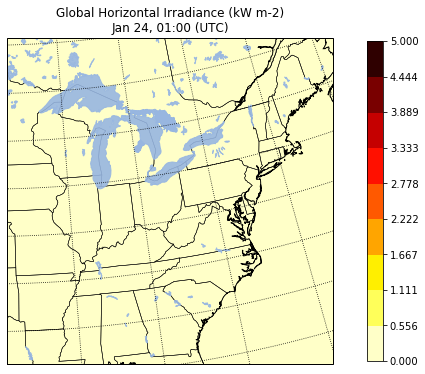

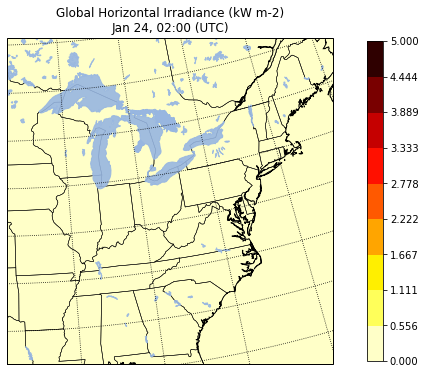

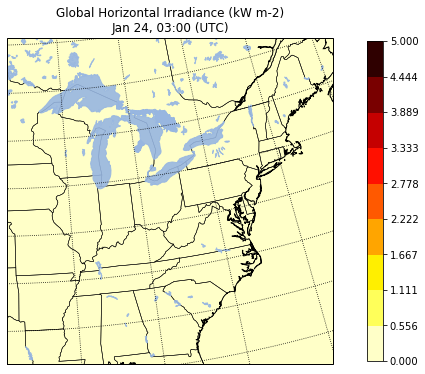

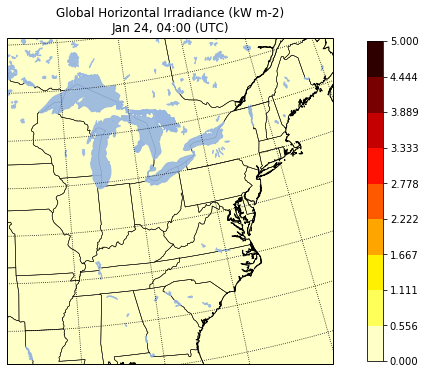

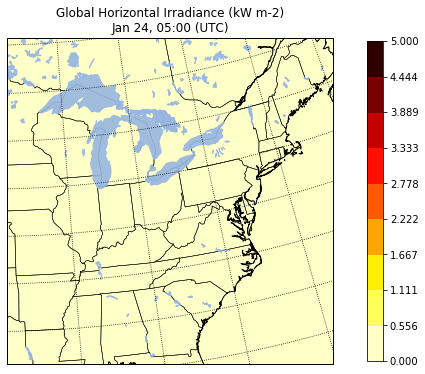

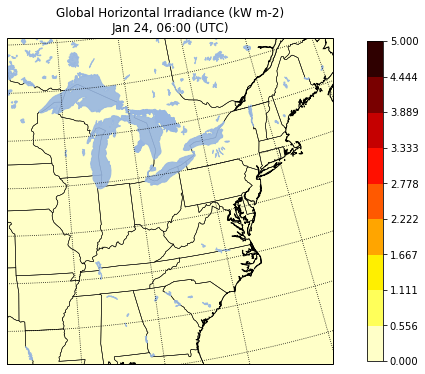

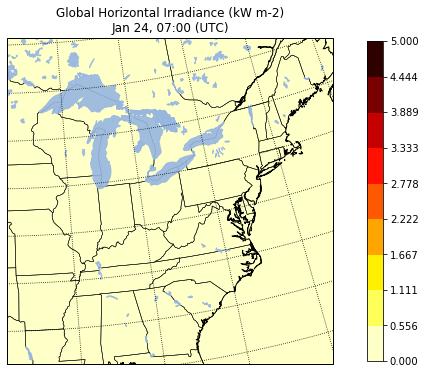

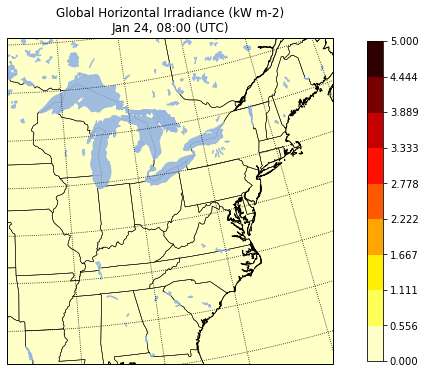

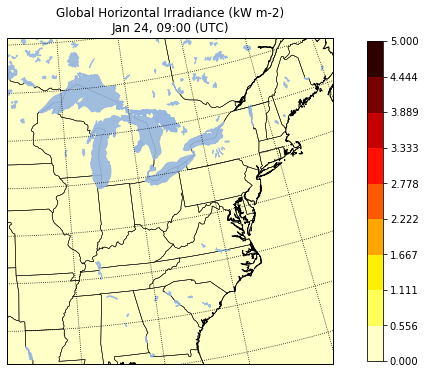

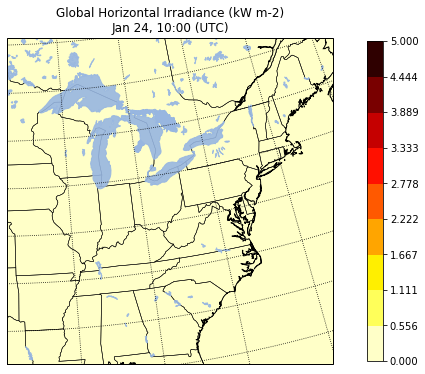

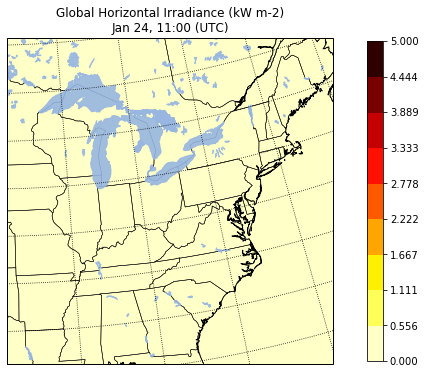

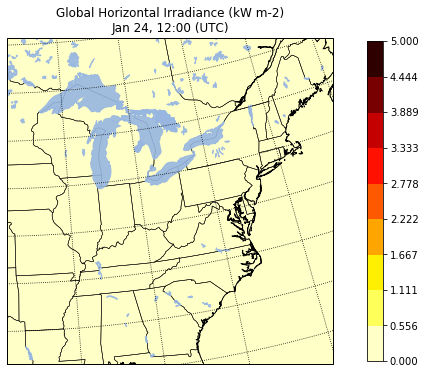

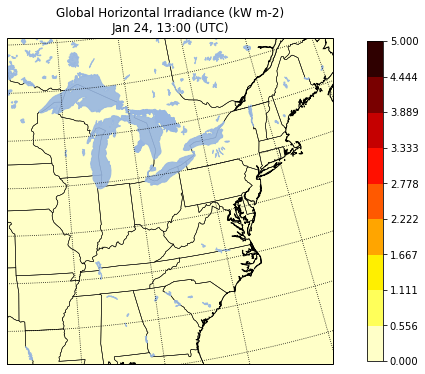

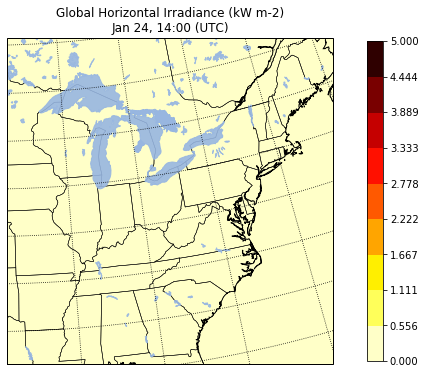

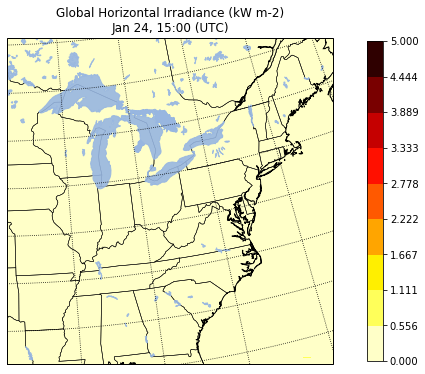

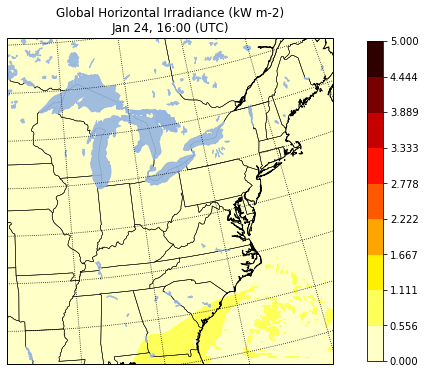

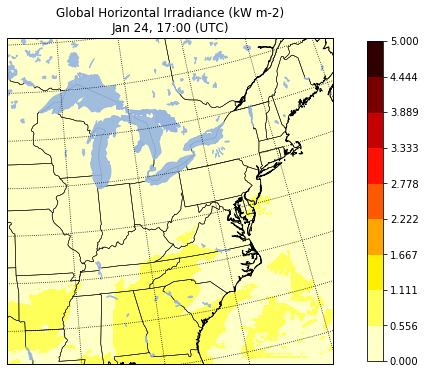

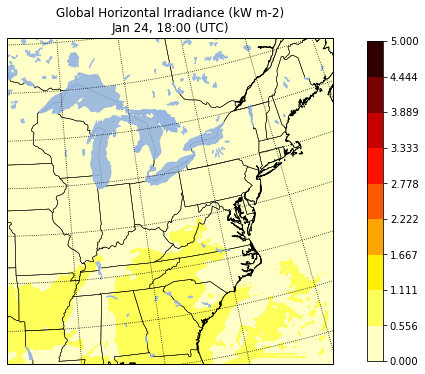

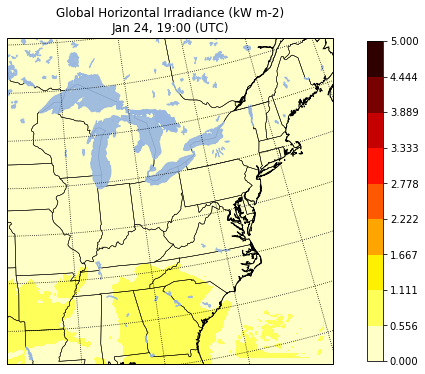

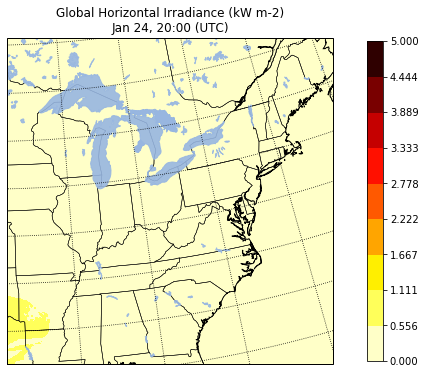

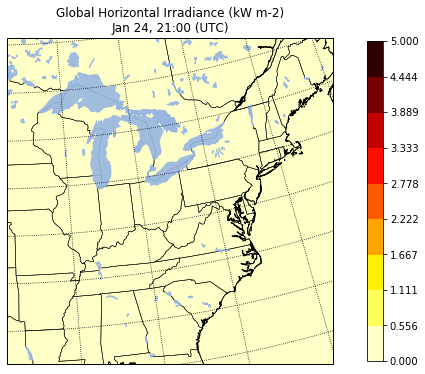

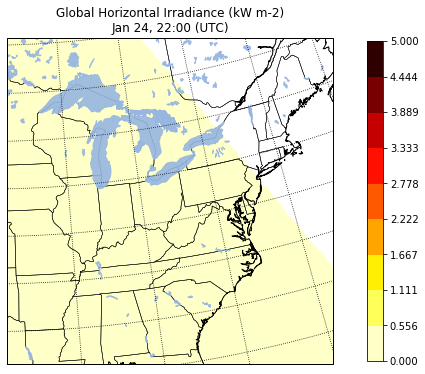

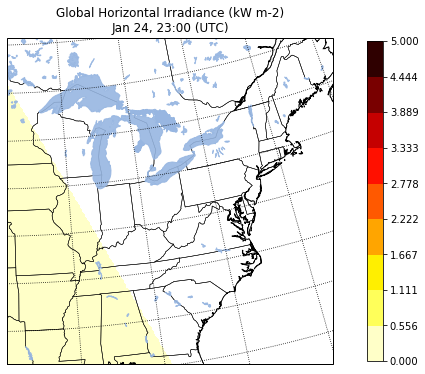

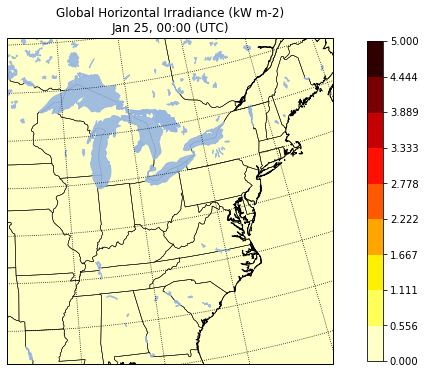

In [122]:
plot_daily_GHI(ncdata.Time, hourly=True)

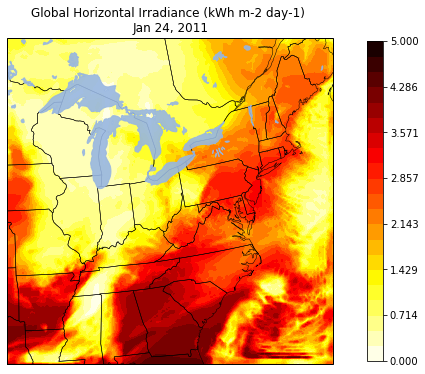

In [175]:
datestr = ncdata['Time'][0].dt.strftime('%b %d, %Y').values
fig_path = f'/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/figures/daily_GHI_plot_{datestr}.png'
plot_daily_GHI(ncdata.Time, hourly=False, save_fig=True, fig_path=fig_path)